## Introduction

In this notebook I will train and test a Convolutional Neural Network (CNN) model to classify images of playing cards. This is a two-dimensional classification problem, with the goal of identifying both the suit (clubs, spades, hearts, diamonds) and the rank (numbers 2-10, jack, queen, king, ace) of the cards. The data for this task comes from the Kaggle competition, "Cards Image Dataset - Classification", __https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification__

First, I will import the required libraries:

In [66]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from keras import models, layers, Input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

A CSV file contains paths to the images along with four other columns: class index, labels, card type, and data set. There is no column for the suit, so I have will have to extract that from the labels. For the purposes of this report, the data set column doesn't matter; I will create my own training and validation datasets. 

In [2]:
path = "/kaggle/input/cards-image-datasetclassification/"
df = pd.read_csv(path + "cards.csv")
df = df[df['filepaths'].str.endswith('.jpg')] # Have only images in the dataframe
df.sample(10)

,class index,filepaths,labels,card type,data set
1602,10,train/five of hearts/129.jpg,five of hearts,five,train
215,1,train/ace of diamonds/095.jpg,ace of diamonds,ace,train
2133,14,train/four of hearts/095.jpg,four of hearts,four,train
175,1,train/ace of diamonds/055.jpg,ace of diamonds,ace,train
1589,10,train/five of hearts/116.jpg,five of hearts,five,train
6815,47,train/three of hearts/019.jpg,three of hearts,three,train
6483,44,train/ten of spades/124.jpg,ten of spades,ten,train
5079,35,train/seven of hearts/025.jpg,seven of hearts,seven,train
7154,49,train/two of clubs/103.jpg,two of clubs,two,train
4754,32,train/queen of spades/094.jpg,queen of spades,queen,train


## Exploratory Data Analysis

A quick look at the data shows there are 8,154 entries in the dataframe and 8,154 unique file paths, meaning there are no duplicated rows. There are 53 unique card labels: 4 suits times 13 ranks, plus jokers. The number of counts of each label range from 118 to 191, a fairly well-balanced sample. 

In [3]:
print(len(df))
print(df['labels'].nunique())
print(df['filepaths'].nunique())
df['labels'].value_counts()

8154
53
8154


labels
ace of spades        191
jack of spades       182
ace of hearts        181
jack of clubs        181
jack of hearts       178
seven of spades      175
queen of diamonds    173
queen of spades      172
queen of clubs       171
jack of diamonds     170
eight of diamonds    169
five of spades       168
ten of spades        168
six of spades        168
four of clubs        167
two of spades        165
two of hearts        165
four of hearts       164
nine of spades       164
three of diamonds    163
eight of hearts      162
six of clubs         162
ten of diamonds      161
king of spades       161
five of clubs        160
seven of hearts      153
three of spades      152
ten of clubs         151
four of spades       150
queen of hearts      149
six of diamonds      149
five of diamonds     148
eight of clubs       148
five of hearts       146
eight of spades      145
king of diamonds     145
two of diamonds      143
nine of hearts       143
two of clubs         140
ten of hearts     

To look at the distribution of suits, I will extract the suit from the labels column and create a new column.

In [4]:
def get_suit(label):
    return label.split()[-1] # The last word in the label is the suit

df['suit'] = df['labels'].apply(get_suit)
df.sample(10)

,class index,filepaths,labels,card type,data set,suit
378,2,train/ace of hearts/129.jpg,ace of hearts,ace,train,hearts
2300,15,train/four of spades/108.jpg,four of spades,four,train,spades
2911,19,train/jack of spades/080.jpg,jack of spades,jack,train,spades
2247,15,train/four of spades/055.jpg,four of spades,four,train,spades
4709,32,train/queen of spades/049.jpg,queen of spades,queen,train,spades
7224,50,train/two of diamonds/043.jpg,two of diamonds,two,train,diamonds
7936,9,valid/five of diamonds/2.jpg,five of diamonds,five,valid,diamonds
4074,28,train/nine of spades/031.jpg,nine of spades,nine,train,spades
814,5,train/eight of diamonds/075.jpg,eight of diamonds,eight,train,diamonds
3016,20,train/joker/013.jpg,joker,xxx,train,joker


A histogram of the suits shows a fairly even number of each suit, plus a small number of jokers. The ranks are also farily balanced, ranging from 574 to 711 for each type.

<Axes: >

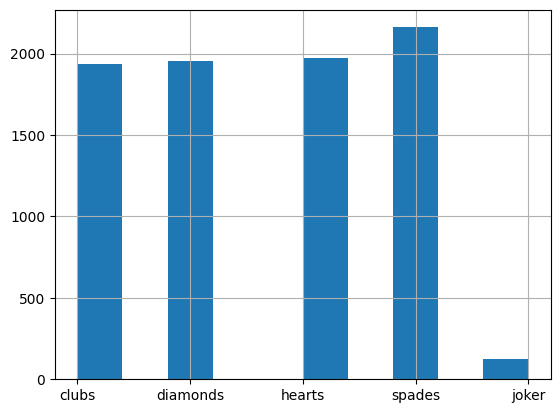

In [5]:
df['suit'].hist()

In [6]:
df['card type'].value_counts()

card type
jack     711
queen    665
ace      641
eight    624
five     622
ten      619
six      616
two      613
four     605
nine     580
seven    580
king     579
three    574
xxx      125
Name: count, dtype: int64

The following function displays a random sample of 12 images of the chosen type.

In [7]:
def view_sample(label = "all"):

    if label == "all":
        samp = df.sample(12)
    else:
        samp = df[df['labels'] == label].sample(12)
        
    imgs = [Image.open(path + f) for f in samp['filepaths']]
    plt.figure()
    f, ax = plt.subplots(2,6,figsize=(15,6))
    for i in range(12):
        ax[i//6][i%6].imshow(imgs[i])

Here is a random sample of images from the entire dataset. Some of the cards look very standard, while others are from odd and unique designs.

<Figure size 640x480 with 0 Axes>

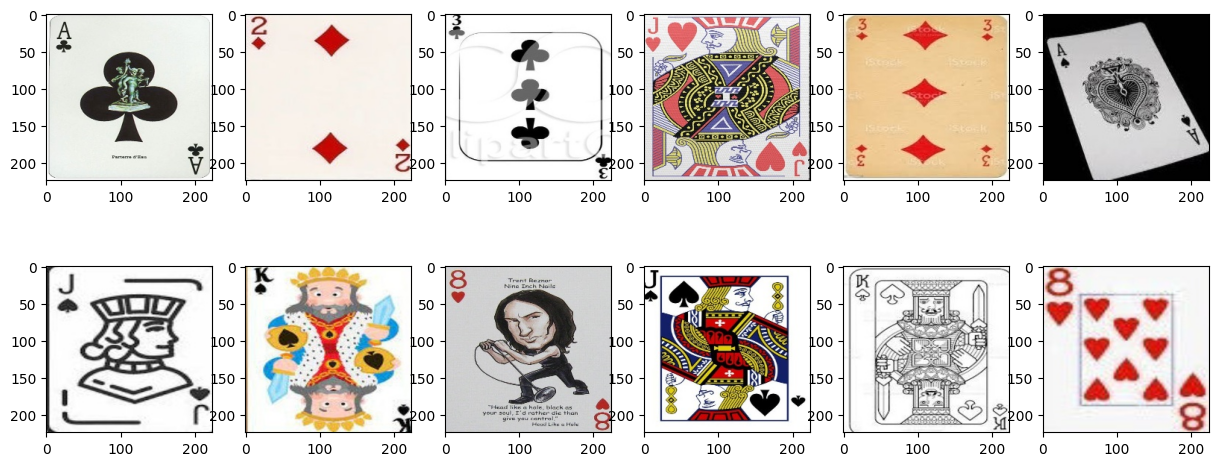

In [8]:
view_sample()

Here is a sample of Aces of Clubs. While they all contain images of A's and clubs, there is some variation in the size and positions of the A's, as well as the color scheme of the card.

<Figure size 640x480 with 0 Axes>

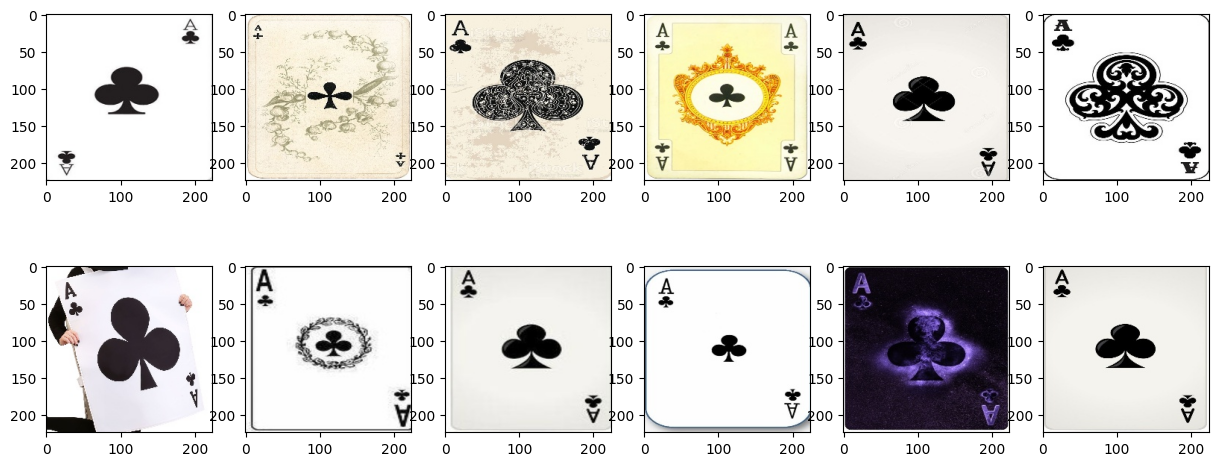

In [9]:
view_sample("ace of clubs")

Here is a sample of Sevens of Diamonds. There are a lot of variations in the patterns, along with some other complications. One card is tilted with part of it missing, and another appears to be partially washed out with bright light.

<Figure size 640x480 with 0 Axes>

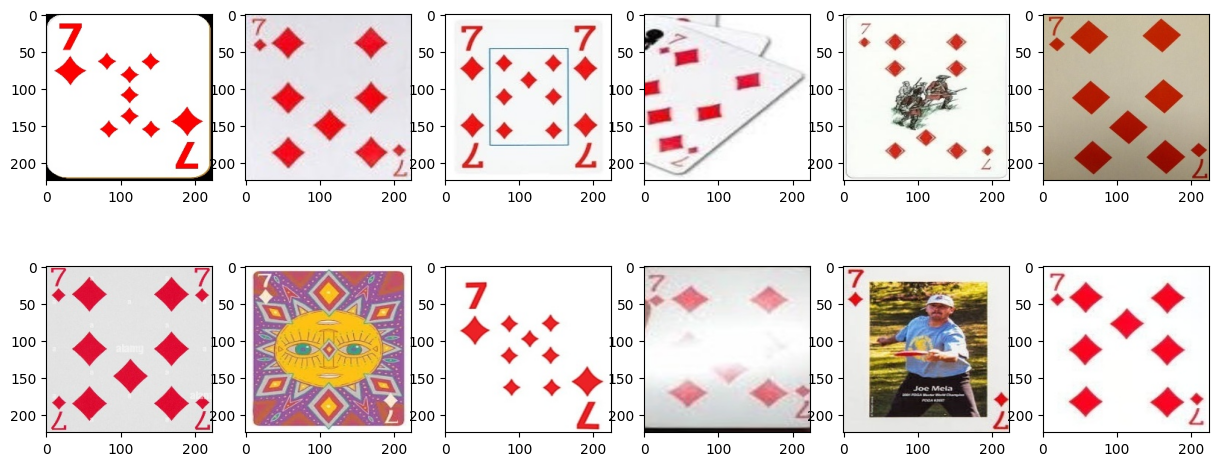

In [10]:
view_sample("seven of diamonds")

Finally, here is a sample of jokers. These cards present a nuisance for the model as they not included in either the 4 suits or the 13 ranks.

<Figure size 640x480 with 0 Axes>

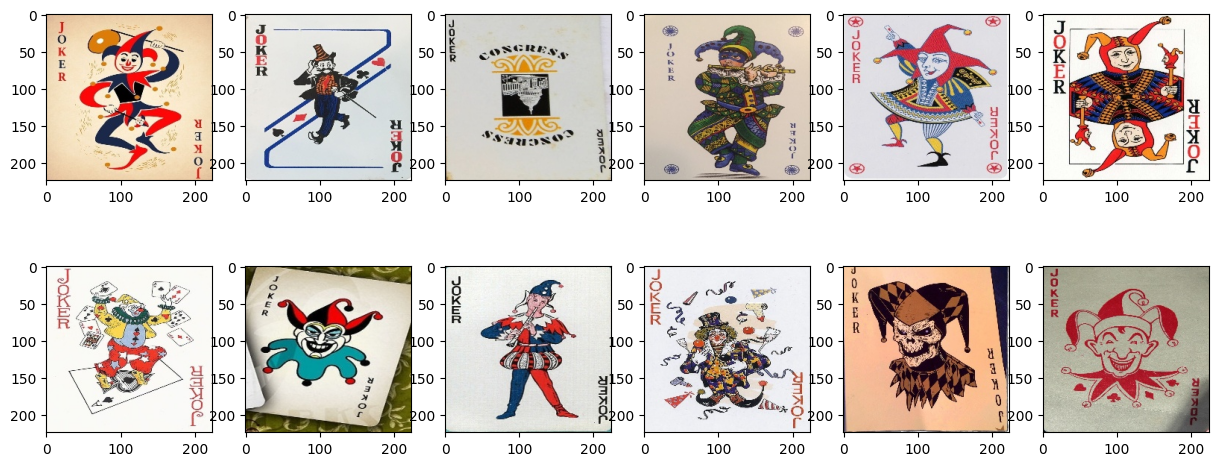

In [11]:
view_sample("joker")

Now let's look at the shape of the image data. Each image has dimensions of 224 x 224 pixels and 3 color values (red, blue, green).

In [12]:
pixel_values = np.array([Image.open(path + f) for f in df['filepaths']])
pixel_values.shape

(8154, 224, 224, 3)

The following code calucates normalized grey-scale pixel values (from 0 to 1) and plots the average value for each image in a histogram. There are no values of 0 or 1, meaning no blank images in the dataset.

In [13]:
imgs_grey = [np.linalg.norm(pv/(255.0*np.sqrt(3)), axis=2) for pv in pixel_values]
df['avg_magnitude'] = np.mean(imgs_grey, axis=(1,2))

<Axes: >

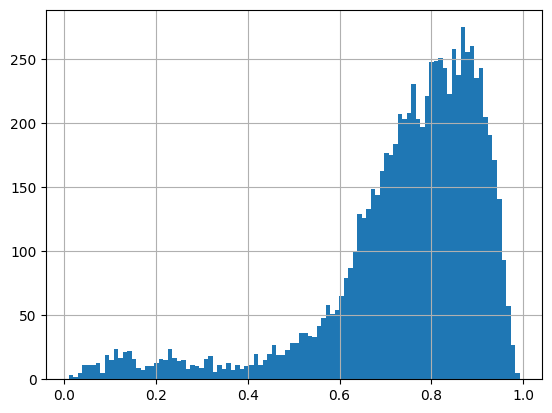

In [14]:
df['avg_magnitude'].hist(bins = 100)

To check whether the dataset contains any duplicate images, I will check whether any two images have the exact same average pixel magnitude.

In [15]:
mags = {}
duplicates = []
m = df['avg_magnitude'].to_list()

for i in range(len(m)):
    if m[i] in mags.keys(): # Check whether magnitude already exists in dictionary
        duplicates.append((mags[m[i]], i))
    else:
        mags[m[i]] = i
        
duplicates


[(1893, 2311), (6721, 6722)]

Two pairs of images have the same average magnitude. However, after plotting them below, I see that this is a coincidence and they are not duplicate images.

<Figure size 640x480 with 0 Axes>

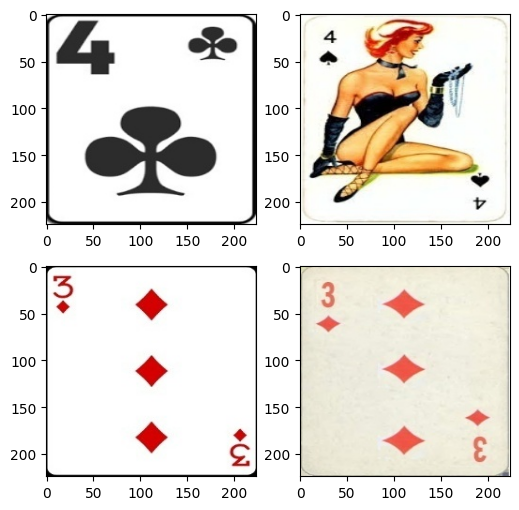

In [16]:
plt.figure()
f, ax = plt.subplots(2,2,figsize=(6,6))
ax[0][0].imshow(Image.open(path + df['filepaths'][1893]))
ax[0][1].imshow(Image.open(path + df['filepaths'][2311]))
ax[1][0].imshow(Image.open(path + df['filepaths'][6721]))
ax[1][1].imshow(Image.open(path + df['filepaths'][6722]))


## Data Preprocessing

To prepare the images for model training, I need to assign numerical labels to the suits and ranks. This is straightforward except for jokers, which don't fit into either category. To make the model work, I assign jokers to a value of 0 in both categories.

In [17]:
suit_dict = {"joker":0, 
             "clubs":1, 
             "spades":2, 
             "hearts":3, 
             "diamonds":4}

rank_dict = {"xxx":0, 
            "ace":1, 
            "two":2, 
            "three":3, 
            "four":4, 
            "five":5, 
            "six":6, 
            "seven":7, 
            "eight":8, 
            "nine":9, 
            "ten":10, 
            "jack":11, 
            "queen":12, 
            "king":13}

def get_suit_idx(suit):
    return suit_dict[suit]

def get_rank_idx(num):
    return rank_dict[num]

df['suit_idx'] = df['suit'].apply(get_suit_idx)
df['rank_idx'] = df['card type'].apply(get_rank_idx)
df.sample(10)

,class index,filepaths,labels,card type,data set,suit,avg_magnitude,suit_idx,rank_idx
2629,17,train/jack of diamonds/126.jpg,jack of diamonds,jack,train,diamonds,0.773841,4,11
4847,33,train/seven of clubs/025.jpg,seven of clubs,seven,train,clubs,0.896990,1,7
960,6,train/eight of hearts/062.jpg,eight of hearts,eight,train,hearts,0.883691,3,8
6490,44,train/ten of spades/131.jpg,ten of spades,ten,train,spades,0.723614,2,10
7930,8,valid/five of clubs/1.jpg,five of clubs,five,valid,clubs,0.833871,1,5
1689,11,train/five of spades/080.jpg,five of spades,five,train,spades,0.239998,2,5
4025,27,train/nine of hearts/115.jpg,nine of hearts,nine,train,hearts,0.736326,3,9
5669,39,train/six of hearts/016.jpg,six of hearts,six,train,hearts,0.841598,3,6
6453,44,train/ten of spades/094.jpg,ten of spades,ten,train,spades,0.742007,2,10
6887,47,train/three of hearts/091.jpg,three of hearts,three,train,hearts,0.903901,3,3


Next, the data needs to be split into training and validation sets. Because the images are ordered by type, I will use the round robin method - assigning every 5th image to the validation set - to ensure that the split is consistent across all types.

In [18]:
df_train = df[df.index % 5 != 4]
df_val = df[df.index % 5 == 4]

x_train = np.array([Image.open(path + f) for f in df_train['filepaths']])
x_val = np.array([Image.open(path + f) for f in df_val['filepaths']])

y0_train = df_train['suit_idx'].to_numpy()
y1_train = df_train['rank_idx'].to_numpy()
y0_val = df_val['suit_idx'].to_numpy()
y1_val = df_val['rank_idx'].to_numpy()

## Model Building and Results

Rather than attempt to train a model on all 53 card types, I will start by training separate models to classify the suit and the rank of the cards. This will simplify the design and allow the models to learn faster by focusing on category-specific features. It will also provide a large and diverse sample for each output class. Training on all 53 types would have a fairly small sample of images (around 120) for each type, but combining them into suits and ranks and training these separately provides more healthy sample sizes (around 1500 per suit, 500 per rank). Based on visual inspection of the cards, there are no obvious interactions between suit and rank; their distinct features are separate from each other, so there should be little downside to splitting the classification task into two separate models.

For the suit model, I will start with a standard convolutional neural network with four 3x3 convolution layers each followed by a max pooling layer. The initial number of filters is set to 32 and doubles at each convolution layer. I also add a dense neural network layer with 1024 nodes and a dropout layer to reduce overfitting. The resulting model has over 38 million parameters.

In [19]:
suit_model1 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

suit_model1.summary()

I0000 00:00:1759039068.032312    2747 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    37,749,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,143,301 (145.51 MB)

 Trainable params: 38,143,301 (145.51 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
suit_model1.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

suit_model1.fit(x_train, y0_train, 
                validation_data=(x_val, y0_val), 
                epochs=20, batch_size=32
)

Epoch 1/20


I0000 00:00:1759039074.016517    2801 service.cc:148] XLA service 0x7fc0000038e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759039074.016576    2801 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759039074.264817    2801 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/204 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.2445 - loss: 675.4829

I0000 00:00:1759039078.257294    2801 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


204/204 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.4061 - loss: 78.9013 - val_accuracy: 0.5886 - val_loss: 0.9181
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6335 - loss: 0.8098 - val_accuracy: 0.6481 - val_loss: 0.7468
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7497 - loss: 0.5759 - val_accuracy: 0.7934 - val_loss: 0.5290
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8740 - loss: 0.3346 - val_accuracy: 0.8099 - val_loss: 0.5581
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9242 - loss: 0.2088 - val_accuracy: 0.8357 - val_loss: 0.5391
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9442 - loss: 0.1529 - val_accuracy: 0.8191 - val_loss: 0.5814
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9467 - loss: 0.1491 - val_accuracy: 0.8345 - val_loss: 0.6020
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9439 - loss: 0.1800 - val_accuracy: 0.8

The following functions plot the training and validation accuracy vs epoch and find the epoch with the best validation accuracy:

In [24]:
def plot_history(model_history):
    train_acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    n = len(train_acc)
    epoch = range(1, n+1)

    plt.plot(epoch, train_acc, label='Training Accuracy')
    plt.plot(epoch, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(0, n+1, 2))
    plt.show()

def Best_acc(model_history):
    best_acc = 0
    best_epoch = 0
    val_acc = model_history.history['val_accuracy']
    
    for i in range(len(val_acc)):
        if val_acc[i] > best_acc:
            best_acc = val_acc[i]
            best_epoch = i+1

    print("Best Epoch: " + str(best_epoch) + ", Accuracy = " + str(best_acc))
    return best_acc, best_epoch

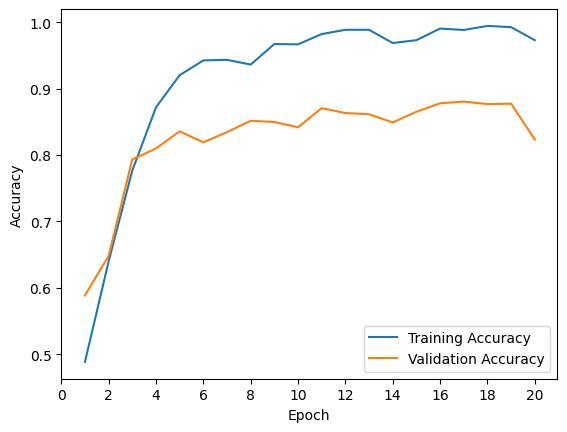

Best Epoch: 17, Accuracy = 0.880441427230835


(0.880441427230835, 17)

In [25]:
plot_history(suit_model1.history)
Best_acc(suit_model1.history)

The validation accuracy of the suit model reached a high point of 88% at the 17th epoch. 

I will next test to see if adding additional layers to the model improves its accuracy. The model below adds an additional 3x3 convolution layer before each pooling layer. I have also doubled the number of filters in each layer. The total number of parameters increases to over 57 million. 

In [22]:
suit_model2 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(64, (3,3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', padding='valid'),
    layers.Conv2D(128, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu', padding='valid'),
    layers.Conv2D(256, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, (3,3), activation='relu', padding='valid'),
    layers.Conv2D(512, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

suit_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 108, 108, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 106, 106, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 51, 51, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 49, 49, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    52,429,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,120,325 (217.90 MB)

 Trainable params: 57,120,325 (217.90 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
suit_model2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

suit_model2.fit(x_train, y0_train, 
                validation_data=(x_val, y0_val), 
                epochs=20, batch_size=32
)

Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 79s 286ms/step - accuracy: 0.2915 - loss: 44.3889 - val_accuracy: 0.5763 - val_loss: 0.9515
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.5897 - loss: 0.9016 - val_accuracy: 0.7106 - val_loss: 0.6434
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.7665 - loss: 0.5509 - val_accuracy: 0.8277 - val_loss: 0.4448
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.8749 - loss: 0.3274 - val_accuracy: 0.8627 - val_loss: 0.4054
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.9336 - loss: 0.1958 - val_accuracy: 0.8847 - val_loss: 0.3588
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.9531 - loss: 0.1440 - val_accuracy: 0.8853 - val_loss: 0.3500
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.9469 - loss: 0.1586 - val_accuracy: 0.8933 - val_loss: 0.3563
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.9603 - loss: 

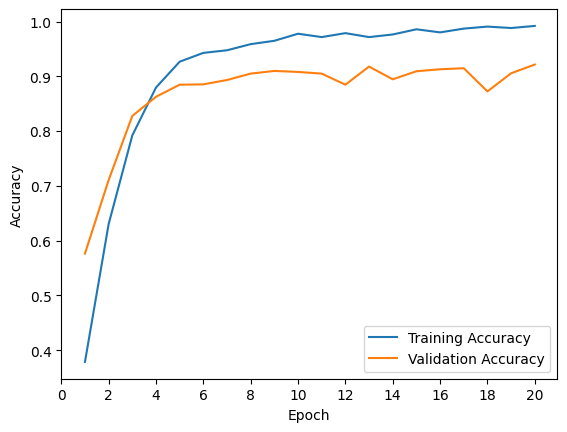

Best Epoch: 20, Accuracy = 0.9215205311775208


(0.9215205311775208, 20)

In [26]:
plot_history(suit_model2.history)
Best_acc(suit_model2.history)

With this deeper model, the validation accuracy improves to 92% after 20 epochs. 

Next, I will look at the results of the model in more detail by plotting a confusion matrix.

In [43]:
y0_pred = suit_model2.predict(x_val)
y0_pred = np.argmax(y0_pred, axis=1) # Choose the suit with maximum probability value

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


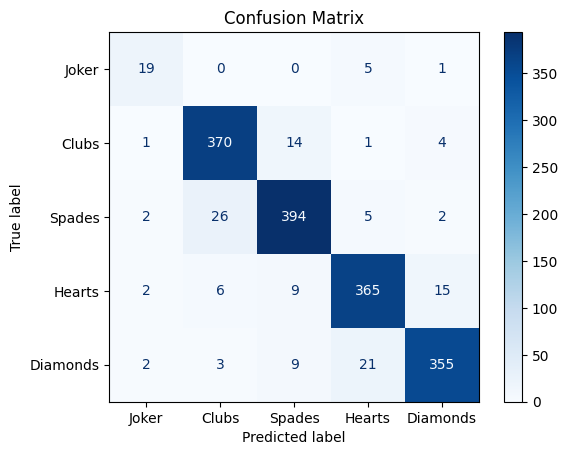

In [39]:
cm = confusion_matrix(y0_val, y0_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=["Joker","Clubs","Spades","Hearts","Diamonds"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Not surprisingly, the confusion matrix shows that the most common errors are mixing up clubs and spades (the black suits) or mixing up hearts and diamonds (red suits). Accuracy is lower for jokers than for the four suits, probably because these have less representation in the training data. Interestingly, there are still a fair number of mix-ups between red and black suits. For example, the model misclassified Clubs as Diamonds 4 times. Below are the four images that were misclassified in this way.

In [50]:
# Find the indices of the 4 images with true label clubs and predicted label diamonds
for i in range(len(y0_pred)):
    if y0_pred[i] == 4 and y0_val[i] == 1:
        print(i)
        

144
648
851
985


<Figure size 640x480 with 0 Axes>

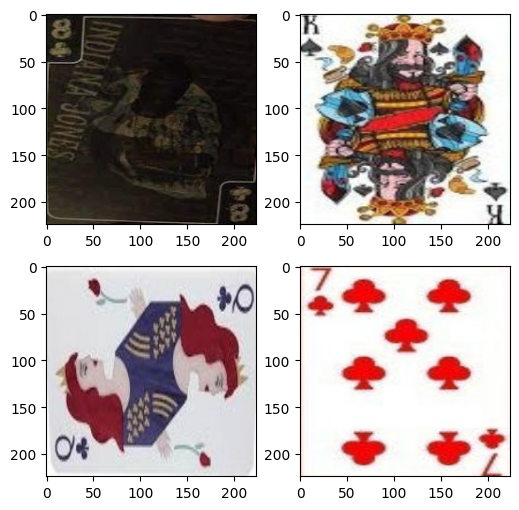

In [53]:
# Display the images at these four indicies
plt.figure()
f, ax = plt.subplots(2,2,figsize=(6,6))
ax[0][0].imshow(Image.open(path + df_val['filepaths'].iloc[144]))
ax[0][1].imshow(Image.open(path + df_val['filepaths'].iloc[648]))
ax[1][0].imshow(Image.open(path + df_val['filepaths'].iloc[851]))
ax[1][1].imshow(Image.open(path + df_val['filepaths'].iloc[985]))

There are interesting observations in each of these four images. The 8 card is difficult to read and the club shape is blurry, so it's not surprising that the model had difficulty with this one. The queen card is sideways, and it's possible that the red flowers were misinterpreted as diamonds. The 7 of clubs is presented in red as opposed to the traditional black, and the pedals of the clubs are also not very distinctive. Finally, the king card appears to be a spade, even though its "true" label is clubs. This appears to be a human error in the labeling of the training data.

In [54]:
df_val['filepaths'].iloc[648]

'train/king of clubs/126.jpg'

Now it is time to train the second CNN, this one for classifying the rank of the cards. I will use the same architecture as the more successful suit model, but with 14 output nodes instead of 5. 

In [40]:
rank_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(64, (3,3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu', padding='valid'),
    layers.Conv2D(128, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu', padding='valid'),
    layers.Conv2D(256, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512, (3,3), activation='relu', padding='valid'),
    layers.Conv2D(512, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(14, activation='softmax')
])

rank_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

rank_model.fit(x_train, y1_train, 
                validation_data=(x_val, y1_val), 
                epochs=20, batch_size=32
)

Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 43s 179ms/step - accuracy: 0.3084 - loss: 17.9293 - val_accuracy: 0.6352 - val_loss: 1.2244
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.6914 - loss: 1.0037 - val_accuracy: 0.6922 - val_loss: 1.0269
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.7675 - loss: 0.7405 - val_accuracy: 0.7321 - val_loss: 0.9158
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.8370 - loss: 0.5329 - val_accuracy: 0.7308 - val_loss: 1.0916
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.8777 - loss: 0.4027 - val_accuracy: 0.7425 - val_loss: 1.0481
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.9145 - loss: 0.2998 - val_accuracy: 0.7388 - val_loss: 1.2408
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.9331 - loss: 0.2304 - val_accuracy: 0.7443 - val_loss: 1.3942
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.9476 - loss: 

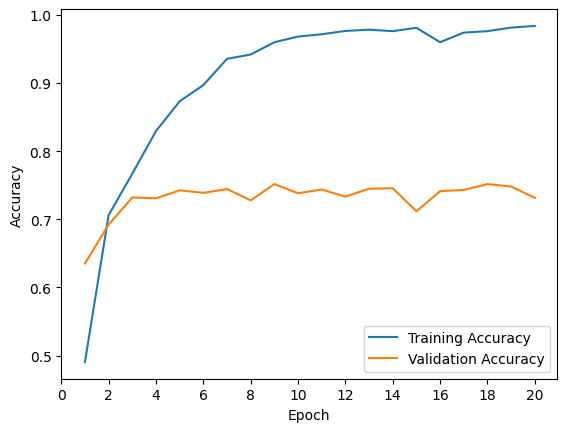

Best Epoch: 9, Accuracy = 0.7516860961914062


(0.7516860961914062, 9)

In [41]:
plot_history(rank_model.history)
Best_acc(rank_model.history)

The accuracy for rank reaches a high of 75% at the 9th epoch. It is not surprising that it's accuracy is lower than the suit model, because there are more ranks than suits and thus more chances for mistakes to occur. 

Below is the confusion matrix for the rank results:

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step


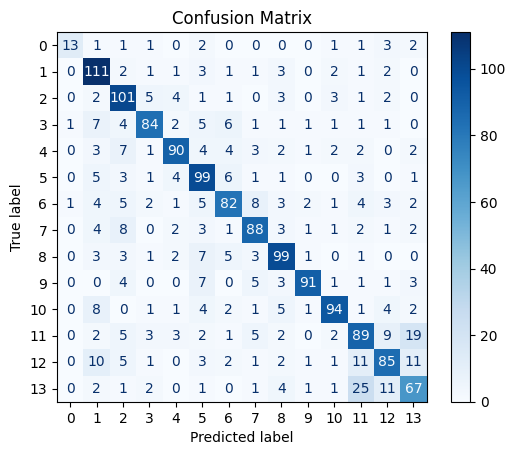

In [55]:
y1_pred = rank_model.predict(x_val)
y1_pred = np.argmax(y1_pred, axis=1)

cm = confusion_matrix(y1_val, y1_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

The most common errors appear to have occurred between the face cards - jacks, queens, and kings - with kings being the most difficult rank to correctly classify. Accuracy is higher for the number cards, but it is not perfect. To pick one example, I am curious as to how the model could have labeled 10's as 5's. The four cards for which this happened are shown below. 

In [57]:
# Find the indices of the 4 images with true label 10 and predicted label 5
for i in range(len(y1_pred)):
    if y1_pred[i] == 5 and y1_val[i] == 10:
        print(i)

1206
1222
1230
1244


<Figure size 640x480 with 0 Axes>

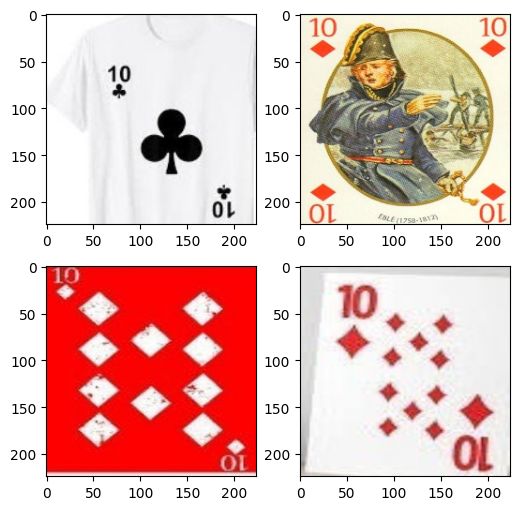

In [58]:
plt.figure()
f, ax = plt.subplots(2,2,figsize=(6,6))
ax[0][0].imshow(Image.open(path + df_val['filepaths'].iloc[1206]))
ax[0][1].imshow(Image.open(path + df_val['filepaths'].iloc[1222]))
ax[1][0].imshow(Image.open(path + df_val['filepaths'].iloc[1230]))
ax[1][1].imshow(Image.open(path + df_val['filepaths'].iloc[1244]))

There are a couple of oddities here. The top left image is of a shirt, not a card, though it is clearly a 10 of clubs. The bottom left image is unusual because it shows white diamonds on a red background instead of the traditional red diamonds on a white background. The bottom right image looks standard, but I notice that the 10 diamonds in the middle are in two groups of 5, perhaps making its features appear close to that of a 5. Finally, for the top right image, it's possible that the model was fooled by the 5 buttons on the soldier's jacket.

If the accuracies of the two separate models were multiplied, the combined accuracy would be about 67%. The actual combined accuracy, as shown below, is about 70%. This suggest that there is at least a small correlation between errors - cards misclassified in one model are more likely to be misclassified in the other.

In [64]:
# Calculated combined accuracy of the two models
n = len(y0_pred)
acc = 0
for i in range(n):
    if y0_pred[i] == y0_val[i] and y1_pred[i] == y1_val[i]:
        acc = acc + 1

print(0.9215*0.7315) # Predicted accuracy if errors were independent
print("Combined accuracy =", acc/n)

0.6740772500000001
Combined accuracy = 0.6983445738810545


Finally, I will test a single CNN model with two output classes, to see if there is any improvement over the two separate models. This model uses two separate loss functions for suit and rank and weighs them equally for the overall loss function. The results are shown below.

In [84]:
inputs = Input(shape=(224,224,3))

x = layers.Conv2D(64, (3,3), activation='relu', padding='valid')(inputs)
x = layers.Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='valid')(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='valid')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(256, (3,3), activation='relu', padding='valid')(x)
x = layers.Conv2D(256, (3,3), activation='relu', padding='valid')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(512, (3,3), activation='relu', padding='valid')(x)
x = layers.Conv2D(512, (3,3), activation='relu', padding='valid')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.25)(x)

# Two classification heads
suit_output = layers.Dense(5, activation='softmax', name="suit")(x)
rank_output = layers.Dense(14, activation='softmax', name="rank")(x)

# Define the multi-output model
model = models.Model(inputs=inputs, outputs=[suit_output, rank_output])

# Compile with separate losses for each head
model.compile(
    optimizer="adam",
    loss={
        "suit": "sparse_categorical_crossentropy",
        "rank": "sparse_categorical_crossentropy"
    },
    metrics={
        "suit": "accuracy",
        "rank": "accuracy"
    }
)

In [85]:
model.fit(x_train, {"suit": y0_train, "rank": y1_train},     
    validation_data=(x_val, {"suit": y0_val, "rank": y1_val}),
    epochs=20,
    batch_size=32
)

Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 45s 181ms/step - loss: 20.8204 - rank_accuracy: 0.1479 - rank_loss: 9.4525 - suit_accuracy: 0.3023 - suit_loss: 11.3679 - val_loss: 2.1603 - val_rank_accuracy: 0.5788 - val_rank_loss: 1.4033 - val_suit_accuracy: 0.6781 - val_suit_loss: 0.7568
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - loss: 1.8930 - rank_accuracy: 0.6187 - rank_loss: 1.2560 - suit_accuracy: 0.7432 - suit_loss: 0.6370 - val_loss: 1.4800 - val_rank_accuracy: 0.6732 - val_rank_loss: 1.0686 - val_suit_accuracy: 0.8430 - val_suit_loss: 0.4110
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - loss: 1.2766 - rank_accuracy: 0.7214 - rank_loss: 0.8945 - suit_accuracy: 0.8561 - suit_loss: 0.3821 - val_loss: 1.3736 - val_rank_accuracy: 0.6965 - val_rank_loss: 0.9983 - val_suit_accuracy: 0.8584 - val_suit_loss: 0.3752
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - loss: 0.8754 - rank_accuracy: 0.8005 - rank_loss: 0.6376 - suit_accuracy: 0.9091 - suit_loss: 0.23

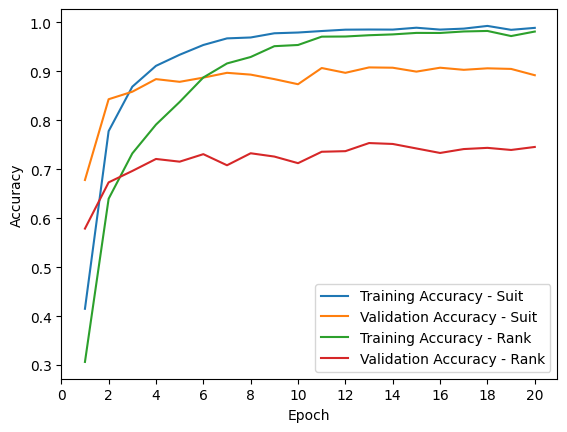

Best Suit Accuracy = 0.9080318808555603
Best Rank Accuracy = 0.75352543592453


In [87]:
train_acc0 = model.history.history['suit_accuracy']
val_acc0 = model.history.history['val_suit_accuracy']
train_acc1 = model.history.history['rank_accuracy']
val_acc1 = model.history.history['val_rank_accuracy']

n = len(train_acc0)
epoch = range(1, n+1)

plt.plot(epoch, train_acc0, label='Training Accuracy - Suit')
plt.plot(epoch, val_acc0, label='Validation Accuracy - Suit')
plt.plot(epoch, train_acc1, label='Training Accuracy - Rank')
plt.plot(epoch, val_acc1, label='Validation Accuracy - Rank')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(0, n+1, 2))
plt.show()

best_acc0 = 0
best_acc1 = 0
    
for i in range(len(val_acc0)):
    if val_acc0[i] > best_acc0:
        best_acc0 = val_acc0[i]
    if val_acc1[i] > best_acc1:
        best_acc1 = val_acc1[i]

print("Best Suit Accuracy = " + str(best_acc0))
print("Best Rank Accuracy = " + str(best_acc1))

The results of this single model are not meaningfully different from the two-model approach. Suit accuracy is slightly worse at 90.8% compared to 92.1% in the suit-only model.

## Conclusion

My convolutional neural network models were able to correctly identify the suit of a playing card about 92% of the time and the rank of the card about 75% of the time. Both categories were classified correctly about 70% of the time. This is a more modest result than I had hoped for, given how clear the features indicating suit and rank usually are (to the human eye) on playing cards. The reason the model didn't perform better likely has to do with the quantity and makeup of the training data. The dataset contained a mixture of playing cards of many different styles. A large portion of the cards had pretty standard designs, but some were quite unusual. In addition, while most of the cards had standard orientation and lighting, some were rotated, occluded, or partially washed out. It is likely that the unusual cards of each type were underrepresented compared to the standard ones, and so the model learned more of the features of the standard cards and struggled to connect them to the features of the unusual cards. Perhaps the model's performance could be improved with data augmentation, such as taking the existing images and rotating them, partially covering them, changing colors, etc., in order to build a more complete training dataset. It is also notable that the data contained at least one mislabeled card. Inspecting all ~8,000 images to fix labeling errors would take a long time, but if a team could be assembled to do it, that would likely improve the results as well.